# Earth-Mars transfer window design using Porkchop Plots
Copyright (c) 2010-2023, Delft University of Technology
All rigths reserved
This file is part of the Tudat. Redistribution and use in source and 
binary forms, with or without modification, are permitted exclusively
under the terms of the Modified BSD license. You should have received
a copy of the license with this file. If not, please or visit:
http://tudat.tudelft.nl/LICENSE.

## Summary
This example demonstrates the usage of the tudatpy `porkchop` module to determine an optimal launch window (departure and arrival date) for an Earth-Mars transfer mission.

By default, the porkchop module uses a Lambert arc to compute the $\Delta V$ required to depart from the departure body (Earth in this case) and be captured by the target body (in this case Mars).

Users can provide a custom function to calculate the $\Delta V$ required for any given transfer. This can be done by supplying a `callable` (a function) to the `porkchop` function via the argument

    function_to_calculate_delta_v

This opens the possibility to calculate the $\Delta V$ required for any transfer; potential applications include: low-thrust transfers, perturbed transfers with course correction manoeuvres, transfers making use of Gravity Assists, and more.

## Import statements

The required import statements are made here, starting with standard imports (`os`, `pickle` from the Python Standard Library), followed by tudatpy imports.

In [11]:
# General imports
import os
import pickle

# Tudat imports
from tudatpy import constants
from tudatpy.interface import spice_interface
from tudatpy.astro.time_conversion import DateTime
from tudatpy.numerical_simulation import environment_setup
from tudatpy.trajectory_design.porkchop import porkchop, plot_porkchop

## Environment setup

We proceed to set up the simulation environment, by loading the standard Spice kernels, defining the origin of the global frame and creating all necessary bodies. 

In [3]:
# Load spice kernels
spice_interface.load_standard_kernels( )

# Define global frame orientation
global_frame_orientation = 'ECLIPJ2000'

# Create bodies
bodies_to_create = ['Sun', 'Venus', 'Earth', 'Moon', 'Mars', 'Jupiter', 'Saturn']
global_frame_origin = 'Sun'
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create, global_frame_origin, global_frame_orientation)

# Create environment model
bodies = environment_setup.create_system_of_bodies(body_settings)

## Porkchop Plots
The departure and target bodies and the time window for the transfer are then defined using tudatpy `astro.time_conversion.DateTime` objects.

In [4]:
departure_body = 'Earth'
target_body = 'Mars'

earliest_departure_time = DateTime(2005,  4,  30)
latest_departure_time   = DateTime(2005, 10,   7)

earliest_arrival_time   = DateTime(2005, 11,  16)
latest_arrival_time     = DateTime(2006, 12,  21)

To ensure the porkchop plot is rendered with good resolution, the time resolution of the plot is defined as 0.5% of the smallest time window (either the arrival or the departure window):

In [5]:
# Set time resolution IN DAYS as 0.5% of the smallest window (be it departure, or arrival)
# This will result in fairly good time resolution, at a runtime of approximately 10 seconds
# Tune the time resolution to obtain results to your liking!
time_window_percentage = 0.5
time_resolution = time_resolution = min(
        latest_departure_time.epoch() - earliest_departure_time.epoch(),
        latest_arrival_time.epoch()   - earliest_arrival_time.epoch()
) / constants.JULIAN_DAY * time_window_percentage / 100

Generating a high-resolution plot may be time-consuming: reusing saved data might be desirable; we proceed to ask the user whether to reuse saved data or generate the plot from scratch.

In [9]:
# File
data_file = 'porkchop.pkl'

# Whether to recalculate the porkchop plot or use saved data
RECALCULATE_delta_v = input(
    '\n    Recalculate ΔV for porkchop plot? [y/N] '
).strip().lower() == 'y'
print()

Lastly, we call the `porkchop` function, which will calculate the $\Delta V$ required at each departure-arrival coordinate and display the plot, giving us

- The optimal departure-arrival date combination
- The constant time-of-flight isochrones
- And more

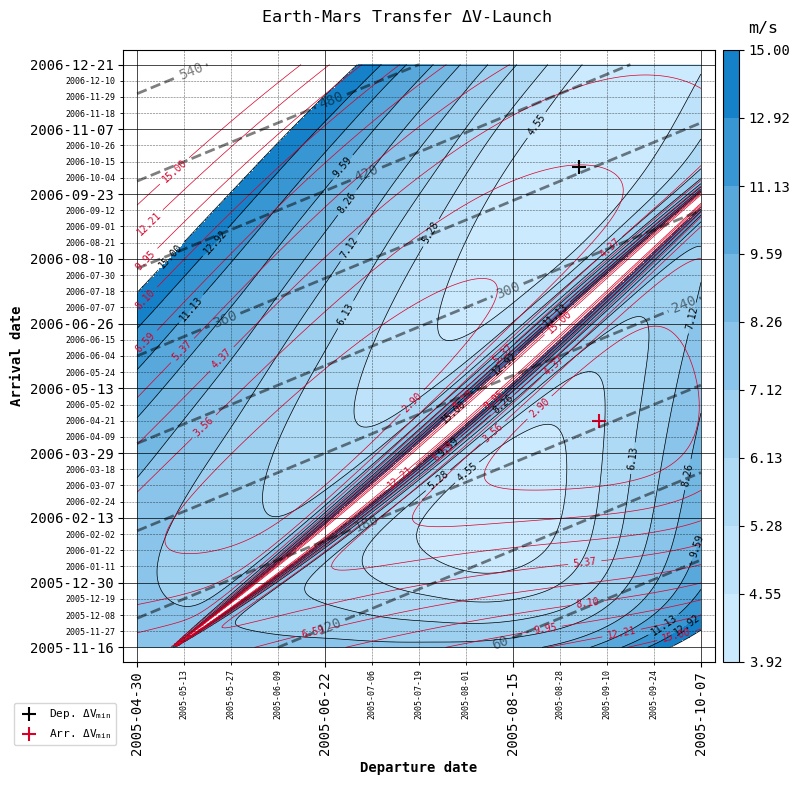

In [15]:
if not os.path.isfile(data_file) or RECALCULATE_delta_v:
    # Regenerate plot
    [departure_epochs, arrival_epochs, ΔV] = porkchop(
        bodies,
        departure_body,
        target_body,
        earliest_departure_time,
        latest_departure_time,
        earliest_arrival_time,
        latest_arrival_time,
        time_resolution
    )
    # Save data
    pickle.dump(
        [departure_epochs, arrival_epochs, ΔV],
        open(data_file, 'wb')
    )
else:
    # Read saved data
    [departure_epochs, arrival_epochs, ΔV] = pickle.load(
        open(data_file, 'rb')
    )
    # Plot saved data
    plot_porkchop(
        departure_body   = departure_body,
        target_body      = target_body,
        departure_epochs = departure_epochs, 
        arrival_epochs   = arrival_epochs, 
        delta_v          = ΔV,
        threshold        = 15
    )

### Variations
The Tudat `porkchop` module allows us to

- Save the $\Delta V$ map returned by `porkchop` and plot it again without recalculating with the `plot_porkchop` function
- Plot $\Delta V$ (default) or C3 (specific energy), as well as choose whether to plot departure and arrival $\Delta V$ together as the total $\Delta V$ required for the transfer (default), or separately (in those cases in which the manoeuvre is performed in two burns, one at departure and one at arrival to the target planet).

Let's make use of `plot_porkchop` to see all four combinations!

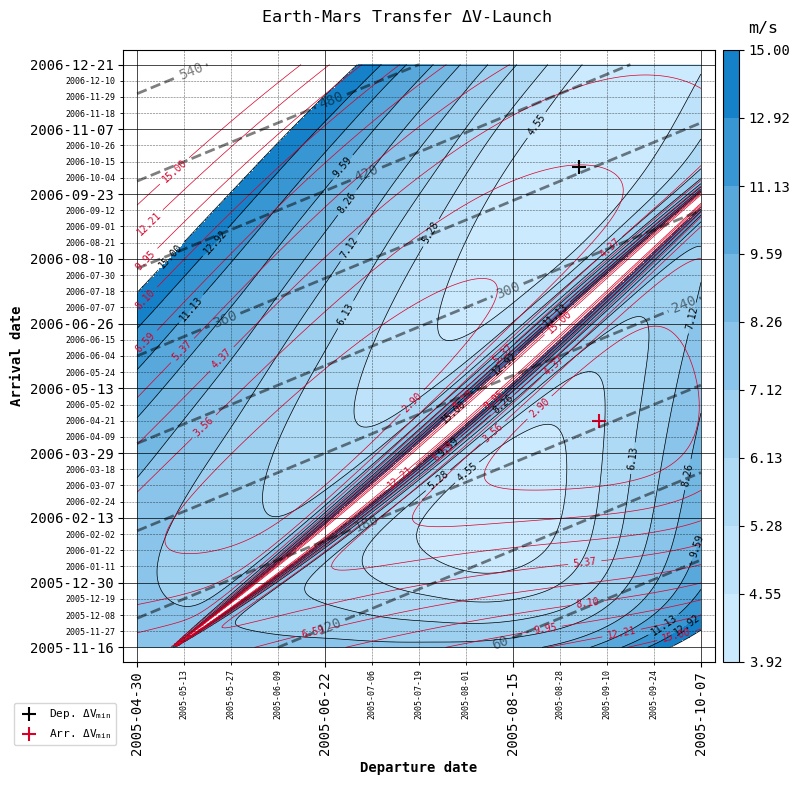

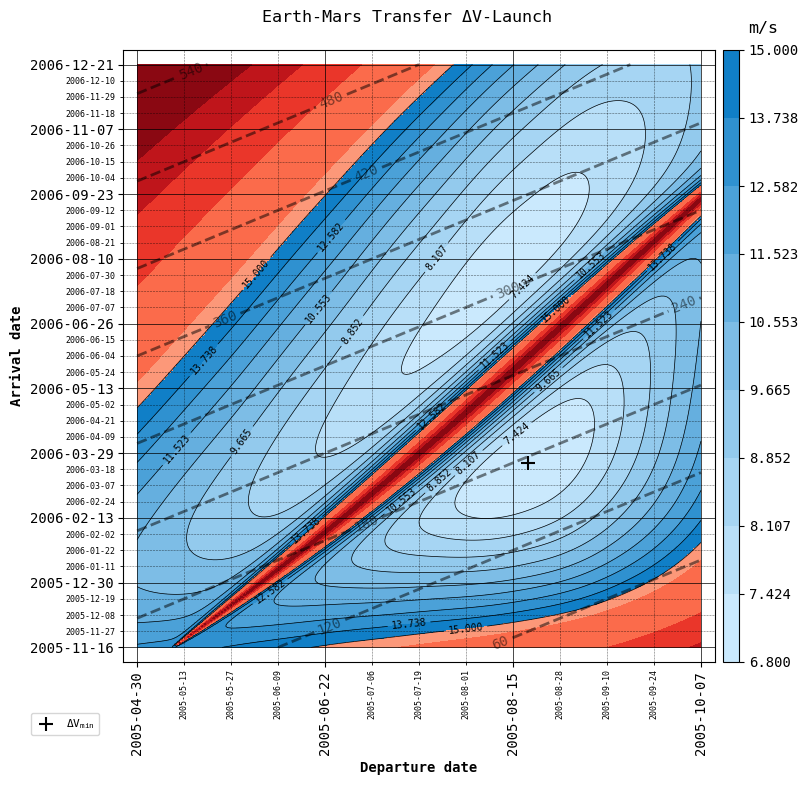

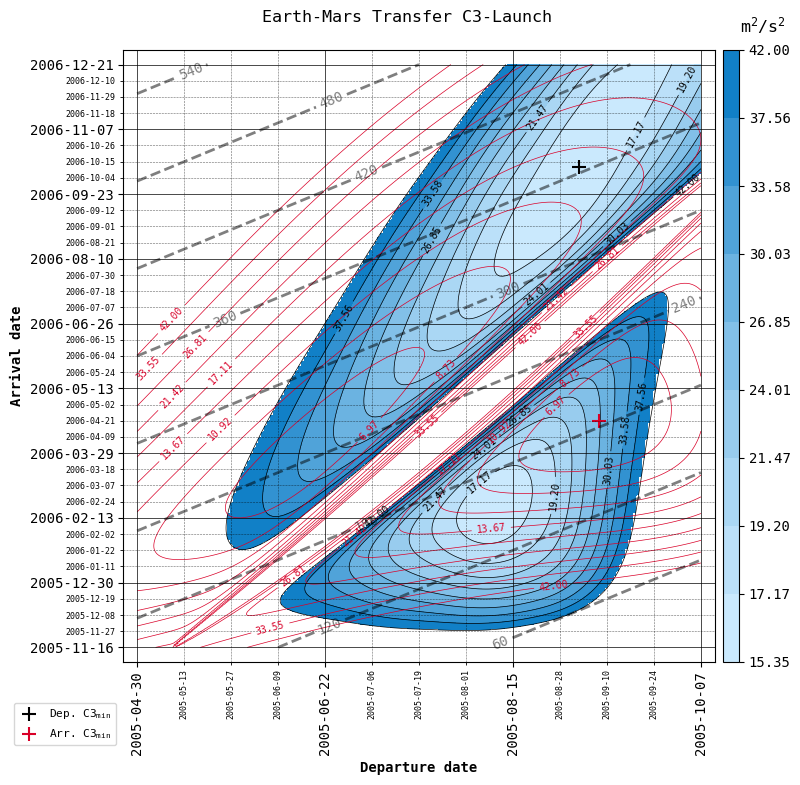

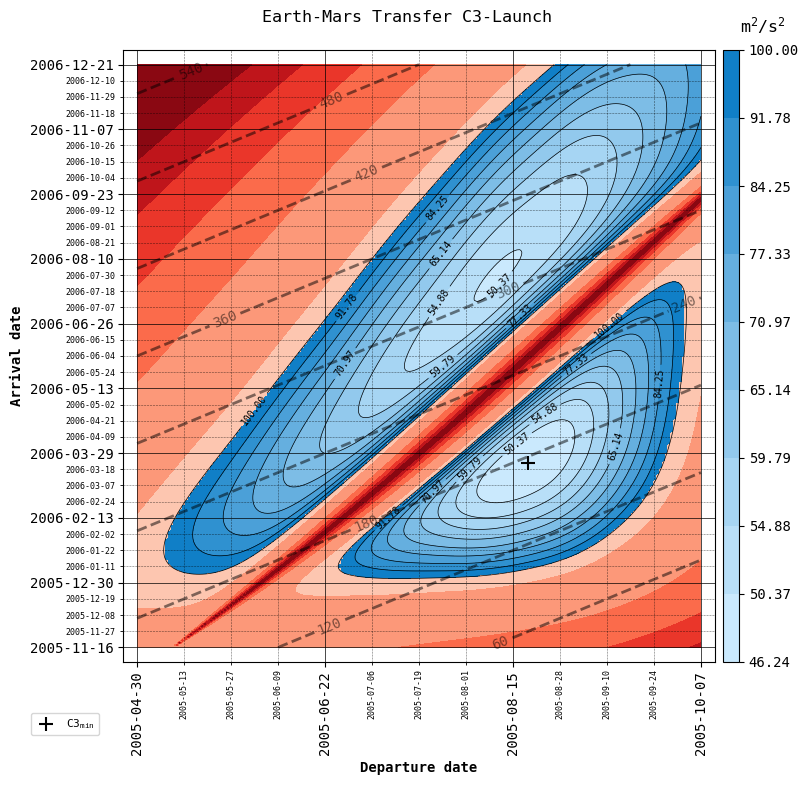

In [8]:
cases = [
    {'C3': False, 'total': False, 'threshold': 15 , 'filename': 'figures/ΔV.png'},
    {'C3': False, 'total': True,  'threshold': 15 , 'filename': 'figures/Δ_tot.png'},
    {'C3': True,  'total': False, 'threshold': 42 , 'filename': 'figures/C3.png'},
    {'C3': True,  'total': True,  'threshold': 100, 'filename': 'figures/C3_tot.png'}
]

for case in cases:
    plot_porkchop(
        departure_body   = departure_body,
        target_body      = target_body,
        departure_epochs = departure_epochs, 
        arrival_epochs   = arrival_epochs, 
        delta_v          = ΔV,
        save             = False,
        **case
    )